# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [79]:
# load weekly sales dataset

filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

<Axes: xlabel='week'>

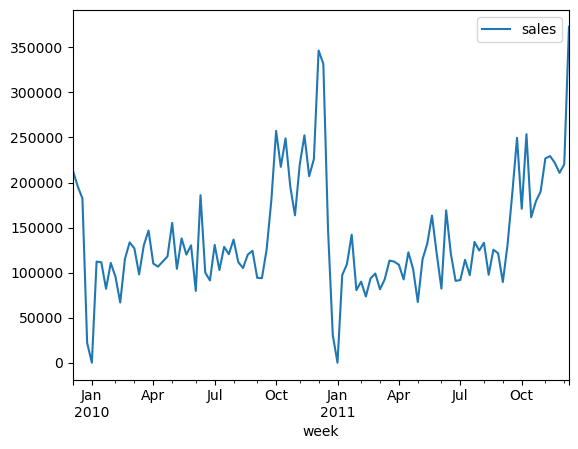

In [80]:
df.plot()

## Missing data

Check if there are missing values in the time series.

In [81]:
df.isna().sum()
# No missing values

sales    0
dtype: int64

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   106 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


## Missing timestamps

Check if there are missing timestamps in the index.

In [83]:
# Create a complate version of data range of min to max date, based on the data frame
complete_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W')
complete_index

DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', length=106, freq='W-SUN')

In [84]:
# Compare the complate version of data range between the actual data frame
missing_timestamps = complete_index.difference(df.index)
missing_timestamps

if len(missing_timestamps) == 0:
    print("No missing values!")
else:
    print(f"there are {len(missing_timestamps)} timesteps")

No missing values!


## Seasonality

Does the time series show any obvious seasonal pattern?
- Yes, we cab see between oct-jan that the selse increasing

<Axes: xlabel='week'>

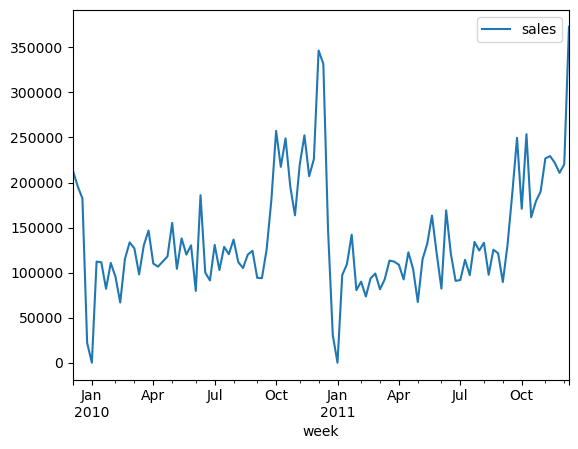

In [85]:
df.plot()

# Feature engineering

Now, let's begin to tabularize the data.

### Time features

In [86]:
df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week
df["Day"] = df.index.day
df["Day_of_week"] = df.index.day_of_week
df["week_of_year"] = df.index.weekofyear

C:\Users\97250\AppData\Local\Temp\ipykernel_11380\237812878.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week_of_year"] = df.index.weekofyear


### Lag features

In [87]:
# Shift the data "sales" in freq of week 
# raw time series
variables = ["sales"]

# Shift the data forward 1 Hr. 
# (we have times seies of hours.)
tmp = df[variables].shift(freq="1W")
 
"""
Names for the new variables.

add to the dataflag object the columns:
    "CO_sensor" + "_lag_1"
    "RH" + "_lag_1"
"""
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

"""
Now, here we shift the varibles "CO_sensor", "RH",
thich stored in tmp. 

"""
df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 6)
data size after
(106, 7)


,sales,Month,Week,Day,Day_of_week,week_of_year,sales_lag_1
week,,,,,,,
2009-12-06,213000.35,12,49,6,6,49,NaN
2009-12-13,195810.04,12,50,13,6,50,213000.35
2009-12-20,182396.74,12,51,20,6,51,195810.04
2009-12-27,22007.77,12,52,27,6,52,182396.74
2010-01-03,0.00,1,53,3,6,53,22007.77


In [88]:
df.head()

,sales,Month,Week,Day,Day_of_week,week_of_year,sales_lag_1
week,,,,,,,
2009-12-06,213000.35,12,49,6,6,49,NaN
2009-12-13,195810.04,12,50,13,6,50,213000.35
2009-12-20,182396.74,12,51,20,6,51,195810.04
2009-12-27,22007.77,12,52,27,6,52,182396.74
2010-01-03,0.00,1,53,3,6,53,22007.77


### Windows features


In [90]:
variables = ["sales"]
window_size = 3  # 3 weeks

tmp = (
    df[variables]
    .rolling(window=window_size, min_periods=1)  # Use a fixed window size
    .mean()  # Calculate the mean within the window
)

# Rename the columns
tmp.columns = [v + "_window" for v in variables]
tmp.head(10)

,sales_window
week,
2009-12-06,213000.350000
2009-12-13,204405.195000
2009-12-20,197069.043333
2009-12-27,133404.850000
2010-01-03,68134.836667
2010-01-10,44775.540000
2010-01-17,74593.106667
2010-01-24,101948.217000
2010-01-31,101438.797333


In [92]:
# Join the new variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 7)
data size after
(106, 8)


,sales,Month,Week,Day,Day_of_week,week_of_year,sales_lag_1,sales_window
week,,,,,,,,
2009-12-06,213000.35,12,49,6,6,49,NaN,213000.350000
2009-12-13,195810.04,12,50,13,6,50,213000.35,204405.195000
2009-12-20,182396.74,12,51,20,6,51,195810.04,197069.043333
2009-12-27,22007.77,12,52,27,6,52,182396.74,133404.850000
2010-01-03,0.00,1,53,3,6,53,22007.77,68134.836667


In [93]:
# double check that its take the avg of the previus 3 weeks. 
(213000.35 + 195810.04 +182396.74)/3

197069.04333333333

### Periodic features 

In [94]:
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(
    variables=["Month", "Week"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

In [95]:
cyclical_vars = [var for var in df.columns if "sin" in var or "cos" in var]

df[cyclical_vars].head()

,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,
2009-12-06,-2.449294e-16,1.000000,-0.456629,0.889657
2009-12-13,-2.449294e-16,1.000000,-0.348202,0.93742
2009-12-20,-2.449294e-16,1.000000,-0.234886,0.972023
2009-12-27,-2.449294e-16,1.000000,-0.118273,0.992981
2010-01-03,5.000000e-01,0.866025,-0.0,1.0


### Cleen the data drom None

In [108]:
df = df.dropna()

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [109]:
X,y = df.drop(["sales"], axis=1), df["sales"]

In [110]:
# Features
X.head()

,Month,Week,Day,Day_of_week,week_of_year,sales_lag_1,sales_window,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,,,,,,,,
2009-12-13,12,50,13,6,50,213000.35,204405.195000,-2.449294e-16,1.000000,-0.348202,0.93742
2009-12-20,12,51,20,6,51,195810.04,197069.043333,-2.449294e-16,1.000000,-0.234886,0.972023
2009-12-27,12,52,27,6,52,182396.74,133404.850000,-2.449294e-16,1.000000,-0.118273,0.992981
2010-01-03,1,53,3,6,53,22007.77,68134.836667,5.000000e-01,0.866025,-0.0,1.0
2010-01-10,1,1,10,6,1,0.00,44775.540000,5.000000e-01,0.866025,0.118273,0.992981


In [111]:
# labels
y.head()

week
2009-12-13    195810.04
2009-12-20    182396.74
2009-12-27     22007.77
2010-01-03         0.00
2010-01-10    112318.85
Name: sales, dtype: float64

In [112]:
split_size = int(0.8 * len(df))

X_train,X_test = X[:split_size],X[split_size:]
y_train,y_test = y[:split_size],y[split_size:]

In [113]:
len(X_train), len(X_test), len(y_train),len(y_test)

(84, 21, 84, 21)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [114]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  49294.94878230015
test rmse:  53576.71221757003


## Machine Learning

In [115]:
# Create the model
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

# Fir the model (train the model on the data)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [116]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  22694.318732188105
test rmse:  36631.15240613266


In [117]:
# Linear regression
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [118]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  25912.446605532452
test rmse:  31632.19166089818


Text(0, 0.5, 'Importance')

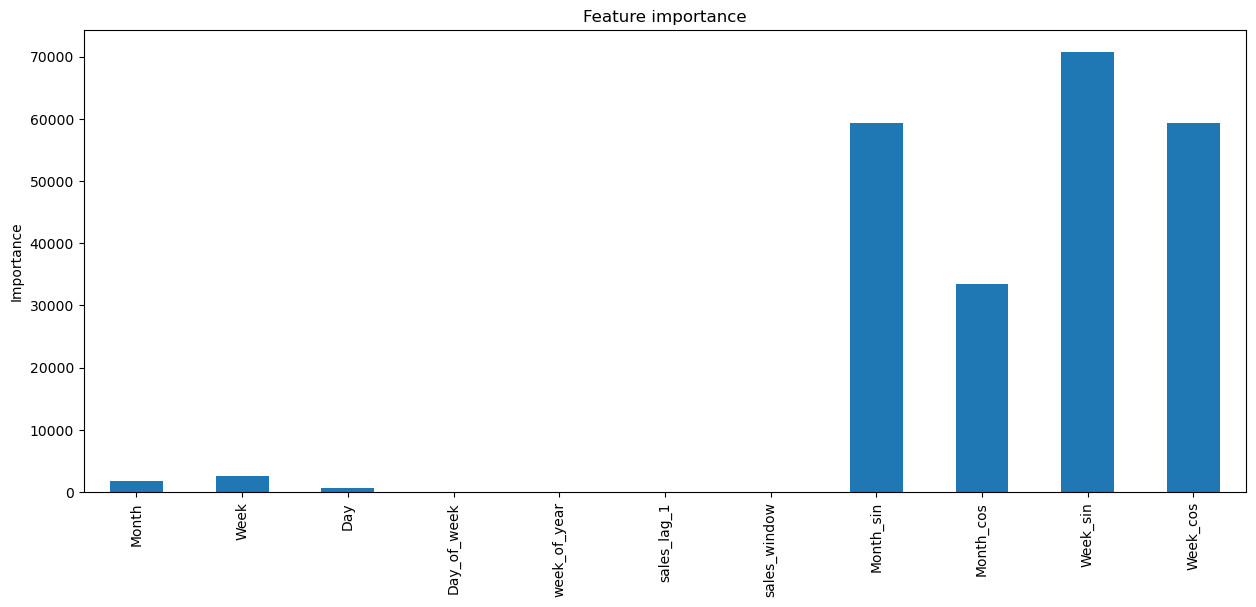

In [119]:
## What is the most usful features for forcast the CO_sensor?

# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")